# Import

In [35]:
import torch
from torch import nn
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR, CosineAnnealingLR
from fvcore.nn import FlopCountAnalysis, flop_count_table
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [36]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
# OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
OPTIMIZER = "NAdam"
"""Learning rate scheduler parameters"""
NUM_EPOCHS = 180

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 150

file_path = f"MyResNet34_{BATCH}_{OPTIMIZER}"

In [37]:
file_path

'MyResNet34_128_NAdam'

# Loading the dataset

## Define Dateloader

In [38]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [39]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [41]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [42]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [43]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [44]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_path)

## (4) Define Learning Rate schedualer

In [45]:
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0)

## (5) Define AMP scaler

In [46]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [47]:
if os.path.exists(file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
MyResNet34_128_NAdam
Current epoch is 22
Current learning rate: 0.002


In [48]:
optimizer.param_groups[0]["lr"]

0.002

In [49]:
earlystopper.early_stop_counter

4

# [Training Loop]

In [50]:
if valid_data is None:
    valid_dataloader = None
if test_data is None:
    test_dataloader = None

In [51]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 23/180] :


23 Train: 100%|██████| 391/391 [00:19<00:00, 20.52it/s]

Train Loss: 0.5162 | Train Acc: 82.09%


Test  Loss: 0.8239 | Test Acc: 74.19%
--------------------------------------------------
[Epoch 24/180] :


24 Train: 100%|██████| 391/391 [00:19<00:00, 20.20it/s]


Train Loss: 0.5172 | Train Acc: 82.04%
Test  Loss: 0.5759 | Test Acc: 81.15%
--------------------------------------------------
[Epoch 25/180] :


25 Train: 100%|██████| 391/391 [00:19<00:00, 20.16it/s]


Train Loss: 0.5092 | Train Acc: 82.48%
Test  Loss: 0.6332 | Test Acc: 79.02%
--------------------------------------------------
[Epoch 26/180] :


26 Train: 100%|██████| 391/391 [00:18<00:00, 20.99it/s]


Train Loss: 0.5081 | Train Acc: 82.47%
Test  Loss: 0.5112 | Test Acc: 82.90%
updated best eval loss : 0.5112344211415399
--------------------------------------------------
[Epoch 27/180] :


27 Train: 100%|██████| 391/391 [00:20<00:00, 18.74it/s]


Train Loss: 0.4984 | Train Acc: 82.80%
Test  Loss: 0.4776 | Test Acc: 83.89%
updated best eval loss : 0.477607347165482
--------------------------------------------------
[Epoch 28/180] :


28 Train: 100%|██████| 391/391 [00:19<00:00, 19.64it/s]


Train Loss: 0.4992 | Train Acc: 82.58%
Test  Loss: 0.5393 | Test Acc: 81.93%
--------------------------------------------------
[Epoch 29/180] :


29 Train: 100%|██████| 391/391 [00:20<00:00, 19.48it/s]


Train Loss: 0.4933 | Train Acc: 82.76%
Test  Loss: 0.5628 | Test Acc: 81.55%
--------------------------------------------------
[Epoch 30/180] :


30 Train: 100%|██████| 391/391 [00:19<00:00, 20.49it/s]


Train Loss: 0.4897 | Train Acc: 83.00%
Test  Loss: 0.6119 | Test Acc: 79.52%
--------------------------------------------------
[Epoch 31/180] :


31 Train: 100%|██████| 391/391 [00:20<00:00, 19.52it/s]


Train Loss: 0.4874 | Train Acc: 83.01%
Test  Loss: 0.6818 | Test Acc: 78.72%
--------------------------------------------------
[Epoch 32/180] :


32 Train: 100%|██████| 391/391 [00:19<00:00, 19.96it/s]


Train Loss: 0.4825 | Train Acc: 83.26%
Test  Loss: 0.4945 | Test Acc: 83.43%
--------------------------------------------------
[Epoch 33/180] :


33 Train: 100%|██████| 391/391 [00:19<00:00, 20.16it/s]


Train Loss: 0.4774 | Train Acc: 83.48%
Test  Loss: 0.4980 | Test Acc: 83.55%
--------------------------------------------------
[Epoch 34/180] :


34 Train: 100%|██████| 391/391 [00:19<00:00, 19.77it/s]


Train Loss: 0.4744 | Train Acc: 83.52%
Test  Loss: 0.4396 | Test Acc: 84.95%
updated best eval loss : 0.4395965326435958
--------------------------------------------------
[Epoch 35/180] :


35 Train: 100%|██████| 391/391 [00:19<00:00, 20.37it/s]


Train Loss: 0.4732 | Train Acc: 83.36%
Test  Loss: 0.5320 | Test Acc: 82.27%
--------------------------------------------------
[Epoch 36/180] :


36 Train: 100%|██████| 391/391 [00:20<00:00, 19.40it/s]


Train Loss: 0.4753 | Train Acc: 83.51%
Test  Loss: 0.4869 | Test Acc: 83.17%
--------------------------------------------------
[Epoch 37/180] :


37 Train: 100%|██████| 391/391 [00:20<00:00, 19.23it/s]


Train Loss: 0.4652 | Train Acc: 83.92%
Test  Loss: 0.4467 | Test Acc: 84.97%
--------------------------------------------------
[Epoch 38/180] :


38 Train: 100%|██████| 391/391 [00:18<00:00, 20.60it/s]


Train Loss: 0.4623 | Train Acc: 84.02%
Test  Loss: 0.5008 | Test Acc: 83.33%
--------------------------------------------------
[Epoch 39/180] :


39 Train: 100%|██████| 391/391 [00:20<00:00, 18.77it/s]


Train Loss: 0.4595 | Train Acc: 83.84%
Test  Loss: 0.5479 | Test Acc: 81.60%
--------------------------------------------------
[Epoch 40/180] :


40 Train: 100%|██████| 391/391 [00:20<00:00, 19.38it/s]


Train Loss: 0.4545 | Train Acc: 84.13%
Test  Loss: 0.5036 | Test Acc: 83.43%
--------------------------------------------------
[Epoch 41/180] :


41 Train: 100%|██████| 391/391 [00:19<00:00, 19.69it/s]


Train Loss: 0.4558 | Train Acc: 84.12%
Test  Loss: 0.5599 | Test Acc: 81.56%
--------------------------------------------------
[Epoch 42/180] :


42 Train: 100%|██████| 391/391 [00:20<00:00, 19.28it/s]


Train Loss: 0.4568 | Train Acc: 84.30%
Test  Loss: 0.4936 | Test Acc: 83.51%
--------------------------------------------------
[Epoch 43/180] :


43 Train: 100%|██████| 391/391 [00:20<00:00, 19.33it/s]


Train Loss: 0.4486 | Train Acc: 84.50%
Test  Loss: 0.5611 | Test Acc: 81.46%
--------------------------------------------------
[Epoch 44/180] :


44 Train: 100%|██████| 391/391 [00:20<00:00, 19.49it/s]


Train Loss: 0.4506 | Train Acc: 84.42%
Test  Loss: 0.4462 | Test Acc: 85.10%
--------------------------------------------------
[Epoch 45/180] :


45 Train: 100%|██████| 391/391 [00:19<00:00, 19.65it/s]


Train Loss: 0.4484 | Train Acc: 84.31%
Test  Loss: 0.4895 | Test Acc: 83.93%
--------------------------------------------------
[Epoch 46/180] :


46 Train: 100%|██████| 391/391 [00:20<00:00, 19.10it/s]


Train Loss: 0.4458 | Train Acc: 84.52%
Test  Loss: 0.4519 | Test Acc: 84.83%
--------------------------------------------------
[Epoch 47/180] :


47 Train: 100%|██████| 391/391 [00:20<00:00, 19.33it/s]


Train Loss: 0.4430 | Train Acc: 84.71%
Test  Loss: 0.6377 | Test Acc: 80.47%
--------------------------------------------------
[Epoch 48/180] :


48 Train: 100%|██████| 391/391 [00:19<00:00, 19.91it/s]


Train Loss: 0.4380 | Train Acc: 84.75%
Test  Loss: 0.5339 | Test Acc: 82.75%
--------------------------------------------------
[Epoch 49/180] :


49 Train: 100%|██████| 391/391 [00:19<00:00, 20.27it/s]


Train Loss: 0.4411 | Train Acc: 84.77%
Test  Loss: 0.4975 | Test Acc: 83.90%
--------------------------------------------------
[Epoch 50/180] :


50 Train: 100%|██████| 391/391 [00:19<00:00, 20.02it/s]


Train Loss: 0.4403 | Train Acc: 84.80%
Test  Loss: 0.4659 | Test Acc: 84.68%
--------------------------------------------------
[Epoch 51/180] :


51 Train: 100%|██████| 391/391 [00:20<00:00, 19.10it/s]


Train Loss: 0.4406 | Train Acc: 84.68%
Test  Loss: 0.5159 | Test Acc: 82.38%
--------------------------------------------------
[Epoch 52/180] :


52 Train: 100%|██████| 391/391 [00:19<00:00, 19.57it/s]


Train Loss: 0.4369 | Train Acc: 84.81%
Test  Loss: 0.5580 | Test Acc: 81.82%
--------------------------------------------------
[Epoch 53/180] :


53 Train: 100%|██████| 391/391 [00:18<00:00, 20.63it/s]


Train Loss: 0.4333 | Train Acc: 84.82%
Test  Loss: 0.4561 | Test Acc: 84.36%
--------------------------------------------------
[Epoch 54/180] :


54 Train: 100%|██████| 391/391 [00:19<00:00, 19.75it/s]


Train Loss: 0.4297 | Train Acc: 85.06%
Test  Loss: 0.6515 | Test Acc: 79.10%
--------------------------------------------------
[Epoch 55/180] :


55 Train: 100%|██████| 391/391 [00:20<00:00, 19.29it/s]


Train Loss: 0.4358 | Train Acc: 84.82%
Test  Loss: 0.4028 | Test Acc: 86.35%
updated best eval loss : 0.40275334104706967
--------------------------------------------------
[Epoch 56/180] :


56 Train: 100%|██████| 391/391 [00:19<00:00, 19.92it/s]


Train Loss: 0.4240 | Train Acc: 85.38%
Test  Loss: 0.4600 | Test Acc: 85.10%
--------------------------------------------------
[Epoch 57/180] :


57 Train: 100%|██████| 391/391 [00:19<00:00, 19.70it/s]


Train Loss: 0.4292 | Train Acc: 85.15%
Test  Loss: 0.4071 | Test Acc: 86.27%
--------------------------------------------------
[Epoch 58/180] :


58 Train: 100%|██████| 391/391 [00:20<00:00, 19.47it/s]


Train Loss: 0.4265 | Train Acc: 85.20%
Test  Loss: 0.4940 | Test Acc: 83.55%
--------------------------------------------------
[Epoch 59/180] :


59 Train: 100%|██████| 391/391 [00:19<00:00, 19.74it/s]


Train Loss: 0.4254 | Train Acc: 85.28%
Test  Loss: 0.4803 | Test Acc: 84.53%
--------------------------------------------------
[Epoch 60/180] :


60 Train: 100%|██████| 391/391 [00:19<00:00, 19.92it/s]


Train Loss: 0.4211 | Train Acc: 85.54%
Test  Loss: 0.5044 | Test Acc: 83.48%
--------------------------------------------------
[Epoch 61/180] :


61 Train: 100%|██████| 391/391 [00:20<00:00, 18.87it/s]


Train Loss: 0.4191 | Train Acc: 85.58%
Test  Loss: 0.7589 | Test Acc: 77.76%
--------------------------------------------------
[Epoch 62/180] :


62 Train: 100%|██████| 391/391 [00:18<00:00, 20.74it/s]


Train Loss: 0.4295 | Train Acc: 85.01%
Test  Loss: 0.5251 | Test Acc: 82.67%
--------------------------------------------------
[Epoch 63/180] :


63 Train: 100%|██████| 391/391 [00:19<00:00, 19.83it/s]


Train Loss: 0.4204 | Train Acc: 85.33%
Test  Loss: 0.4587 | Test Acc: 84.91%
--------------------------------------------------
[Epoch 64/180] :


64 Train: 100%|██████| 391/391 [00:20<00:00, 19.35it/s]


Train Loss: 0.4203 | Train Acc: 85.53%
Test  Loss: 0.5123 | Test Acc: 83.09%
--------------------------------------------------
[Epoch 65/180] :


65 Train: 100%|██████| 391/391 [00:20<00:00, 18.75it/s]


Train Loss: 0.4211 | Train Acc: 85.39%
Test  Loss: 0.5349 | Test Acc: 83.27%
--------------------------------------------------
[Epoch 66/180] :


66 Train: 100%|██████| 391/391 [00:19<00:00, 19.80it/s]


Train Loss: 0.4131 | Train Acc: 85.72%
Test  Loss: 0.6179 | Test Acc: 80.26%
--------------------------------------------------
[Epoch 67/180] :


67 Train: 100%|██████| 391/391 [00:19<00:00, 20.24it/s]


Train Loss: 0.4135 | Train Acc: 85.65%
Test  Loss: 0.4980 | Test Acc: 83.62%
--------------------------------------------------
[Epoch 68/180] :


68 Train: 100%|██████| 391/391 [00:20<00:00, 19.22it/s]


Train Loss: 0.4151 | Train Acc: 85.55%
Test  Loss: 0.4183 | Test Acc: 85.87%
--------------------------------------------------
[Epoch 69/180] :


69 Train: 100%|██████| 391/391 [00:20<00:00, 18.97it/s]


Train Loss: 0.4130 | Train Acc: 85.52%
Test  Loss: 0.5133 | Test Acc: 82.85%
--------------------------------------------------
[Epoch 70/180] :


70 Train: 100%|██████| 391/391 [00:20<00:00, 19.33it/s]


Train Loss: 0.4005 | Train Acc: 85.96%
Test  Loss: 0.5186 | Test Acc: 83.47%
--------------------------------------------------
[Epoch 71/180] :


71 Train: 100%|██████| 391/391 [00:19<00:00, 19.96it/s]


Train Loss: 0.4125 | Train Acc: 85.67%
Test  Loss: 0.4437 | Test Acc: 85.35%
--------------------------------------------------
[Epoch 72/180] :


72 Train: 100%|██████| 391/391 [00:19<00:00, 19.99it/s]


Train Loss: 0.4089 | Train Acc: 85.79%
Test  Loss: 0.5080 | Test Acc: 83.39%
--------------------------------------------------
[Epoch 73/180] :


73 Train: 100%|██████| 391/391 [00:19<00:00, 20.33it/s]


Train Loss: 0.4141 | Train Acc: 85.60%
Test  Loss: 0.5264 | Test Acc: 82.45%
--------------------------------------------------
[Epoch 74/180] :


74 Train: 100%|██████| 391/391 [00:19<00:00, 19.86it/s]


Train Loss: 0.4048 | Train Acc: 85.88%
Test  Loss: 0.4271 | Test Acc: 85.36%
--------------------------------------------------
[Epoch 75/180] :


75 Train: 100%|██████| 391/391 [00:19<00:00, 19.77it/s]


Train Loss: 0.4043 | Train Acc: 86.02%
Test  Loss: 0.4841 | Test Acc: 83.96%
--------------------------------------------------
[Epoch 76/180] :


76 Train: 100%|██████| 391/391 [00:20<00:00, 19.26it/s]


Train Loss: 0.4134 | Train Acc: 85.69%
Test  Loss: 0.5008 | Test Acc: 84.06%
--------------------------------------------------
[Epoch 77/180] :


77 Train: 100%|██████| 391/391 [00:19<00:00, 19.84it/s]


Train Loss: 0.4031 | Train Acc: 86.06%
Test  Loss: 0.4678 | Test Acc: 84.91%
--------------------------------------------------
[Epoch 78/180] :


78 Train: 100%|██████| 391/391 [00:19<00:00, 19.69it/s]


Train Loss: 0.4075 | Train Acc: 85.88%
Test  Loss: 0.4661 | Test Acc: 85.07%
--------------------------------------------------
[Epoch 79/180] :


79 Train: 100%|██████| 391/391 [00:20<00:00, 19.46it/s]


Train Loss: 0.4084 | Train Acc: 85.84%
Test  Loss: 0.4590 | Test Acc: 84.74%
--------------------------------------------------
[Epoch 80/180] :


80 Train: 100%|██████| 391/391 [00:20<00:00, 19.17it/s]


Train Loss: 0.3988 | Train Acc: 86.06%
Test  Loss: 0.4472 | Test Acc: 85.35%
--------------------------------------------------
[Epoch 81/180] :


81 Train: 100%|██████| 391/391 [00:19<00:00, 19.71it/s]


Train Loss: 0.4071 | Train Acc: 85.85%
Test  Loss: 0.6083 | Test Acc: 81.12%
--------------------------------------------------
[Epoch 82/180] :


82 Train: 100%|██████| 391/391 [00:19<00:00, 19.79it/s]


Train Loss: 0.4066 | Train Acc: 86.04%
Test  Loss: 0.5291 | Test Acc: 82.84%
--------------------------------------------------
[Epoch 83/180] :


83 Train: 100%|██████| 391/391 [00:20<00:00, 19.29it/s]


Train Loss: 0.4007 | Train Acc: 86.06%
Test  Loss: 0.5126 | Test Acc: 83.81%
--------------------------------------------------
[Epoch 84/180] :


84 Train: 100%|██████| 391/391 [00:20<00:00, 19.20it/s]


Train Loss: 0.4049 | Train Acc: 86.00%
Test  Loss: 0.6191 | Test Acc: 80.78%
--------------------------------------------------
[Epoch 85/180] :


85 Train: 100%|██████| 391/391 [00:19<00:00, 19.99it/s]


Train Loss: 0.3939 | Train Acc: 86.21%
Test  Loss: 0.5064 | Test Acc: 83.76%
--------------------------------------------------
[Epoch 86/180] :


86 Train: 100%|██████| 391/391 [00:19<00:00, 20.22it/s]


Train Loss: 0.3948 | Train Acc: 86.29%
Test  Loss: 0.5048 | Test Acc: 83.31%
--------------------------------------------------
[Epoch 87/180] :


87 Train: 100%|██████| 391/391 [00:19<00:00, 19.67it/s]


Train Loss: 0.4042 | Train Acc: 86.14%
Test  Loss: 0.4664 | Test Acc: 84.28%
--------------------------------------------------
[Epoch 88/180] :


88 Train: 100%|██████| 391/391 [00:20<00:00, 19.07it/s]


Train Loss: 0.3956 | Train Acc: 86.10%
Test  Loss: 0.5040 | Test Acc: 83.08%
--------------------------------------------------
[Epoch 89/180] :


89 Train: 100%|██████| 391/391 [00:20<00:00, 19.24it/s]


Train Loss: 0.3955 | Train Acc: 86.15%
Test  Loss: 0.5614 | Test Acc: 81.52%
--------------------------------------------------
[Epoch 90/180] :


90 Train: 100%|██████| 391/391 [00:19<00:00, 19.76it/s]


Train Loss: 0.3985 | Train Acc: 86.21%
Test  Loss: 0.5811 | Test Acc: 82.18%
--------------------------------------------------
[Epoch 91/180] :


91 Train: 100%|██████| 391/391 [00:20<00:00, 19.05it/s]


Train Loss: 0.3949 | Train Acc: 86.25%
Test  Loss: 0.5392 | Test Acc: 82.56%
--------------------------------------------------
[Epoch 92/180] :


92 Train: 100%|██████| 391/391 [00:19<00:00, 19.87it/s]


Train Loss: 0.3972 | Train Acc: 86.04%
Test  Loss: 0.4856 | Test Acc: 83.92%
--------------------------------------------------
[Epoch 93/180] :


93 Train: 100%|██████| 391/391 [00:20<00:00, 19.33it/s]


Train Loss: 0.3926 | Train Acc: 86.36%
Test  Loss: 0.4107 | Test Acc: 86.40%
--------------------------------------------------
[Epoch 94/180] :


94 Train: 100%|██████| 391/391 [00:20<00:00, 19.44it/s]


Train Loss: 0.3964 | Train Acc: 86.20%
Test  Loss: 0.5046 | Test Acc: 83.22%
--------------------------------------------------
[Epoch 95/180] :


95 Train: 100%|██████| 391/391 [00:20<00:00, 19.44it/s]


Train Loss: 0.3905 | Train Acc: 86.30%
Test  Loss: 0.4586 | Test Acc: 84.96%
--------------------------------------------------
[Epoch 96/180] :


96 Train: 100%|██████| 391/391 [00:19<00:00, 20.28it/s]


Train Loss: 0.3932 | Train Acc: 86.35%
Test  Loss: 0.5015 | Test Acc: 83.88%
--------------------------------------------------
[Epoch 97/180] :


97 Train: 100%|██████| 391/391 [00:19<00:00, 19.79it/s]


Train Loss: 0.3907 | Train Acc: 86.44%
Test  Loss: 0.5194 | Test Acc: 82.94%
--------------------------------------------------
[Epoch 98/180] :


98 Train: 100%|██████| 391/391 [00:20<00:00, 19.30it/s]


Train Loss: 0.3972 | Train Acc: 86.24%
Test  Loss: 0.4723 | Test Acc: 84.44%
--------------------------------------------------
[Epoch 99/180] :


99 Train: 100%|██████| 391/391 [00:19<00:00, 20.03it/s]


Train Loss: 0.3910 | Train Acc: 86.15%
Test  Loss: 0.6617 | Test Acc: 79.46%
--------------------------------------------------
[Epoch 100/180] :


100 Train: 100%|█████| 391/391 [00:19<00:00, 19.71it/s]


Train Loss: 0.3943 | Train Acc: 86.15%
Test  Loss: 0.5093 | Test Acc: 83.70%
--------------------------------------------------
[Epoch 101/180] :


101 Train: 100%|█████| 391/391 [00:19<00:00, 19.67it/s]


Train Loss: 0.3892 | Train Acc: 86.51%
Test  Loss: 0.5630 | Test Acc: 81.49%
--------------------------------------------------
[Epoch 102/180] :


102 Train: 100%|█████| 391/391 [00:19<00:00, 20.15it/s]


Train Loss: 0.3872 | Train Acc: 86.64%
Test  Loss: 0.3999 | Test Acc: 86.44%
updated best eval loss : 0.3999142578885525
--------------------------------------------------
[Epoch 103/180] :


103 Train: 100%|█████| 391/391 [00:19<00:00, 19.69it/s]


Train Loss: 0.3832 | Train Acc: 86.72%
Test  Loss: 0.4569 | Test Acc: 84.98%
--------------------------------------------------
[Epoch 104/180] :


104 Train: 100%|█████| 391/391 [00:19<00:00, 19.71it/s]


Train Loss: 0.3899 | Train Acc: 86.44%
Test  Loss: 0.4704 | Test Acc: 84.31%
--------------------------------------------------
[Epoch 105/180] :


105 Train: 100%|█████| 391/391 [00:19<00:00, 20.22it/s]


Train Loss: 0.3922 | Train Acc: 86.29%
Test  Loss: 0.4669 | Test Acc: 84.85%
--------------------------------------------------
[Epoch 106/180] :


106 Train: 100%|█████| 391/391 [00:19<00:00, 19.82it/s]


Train Loss: 0.3941 | Train Acc: 86.38%
Test  Loss: 0.4742 | Test Acc: 84.46%
--------------------------------------------------
[Epoch 107/180] :


107 Train: 100%|█████| 391/391 [00:19<00:00, 19.73it/s]


Train Loss: 0.3857 | Train Acc: 86.54%
Test  Loss: 0.5542 | Test Acc: 82.35%
--------------------------------------------------
[Epoch 108/180] :


108 Train: 100%|█████| 391/391 [00:19<00:00, 20.08it/s]


Train Loss: 0.3841 | Train Acc: 86.53%
Test  Loss: 0.4822 | Test Acc: 84.04%
--------------------------------------------------
[Epoch 109/180] :


109 Train: 100%|█████| 391/391 [00:19<00:00, 20.27it/s]


Train Loss: 0.3879 | Train Acc: 86.59%
Test  Loss: 0.5257 | Test Acc: 83.07%
--------------------------------------------------
[Epoch 110/180] :


110 Train: 100%|█████| 391/391 [00:18<00:00, 20.59it/s]


Train Loss: 0.3876 | Train Acc: 86.60%
Test  Loss: 0.3823 | Test Acc: 87.07%
updated best eval loss : 0.3823137006050424
--------------------------------------------------
[Epoch 111/180] :


111 Train: 100%|█████| 391/391 [00:19<00:00, 19.91it/s]


Train Loss: 0.3844 | Train Acc: 86.44%
Test  Loss: 0.6807 | Test Acc: 78.96%
--------------------------------------------------
[Epoch 112/180] :


112 Train: 100%|█████| 391/391 [00:19<00:00, 19.55it/s]


Train Loss: 0.3888 | Train Acc: 86.46%
Test  Loss: 0.4316 | Test Acc: 85.17%
--------------------------------------------------
[Epoch 113/180] :


113 Train: 100%|█████| 391/391 [00:20<00:00, 19.10it/s]


Train Loss: 0.3859 | Train Acc: 86.58%
Test  Loss: 0.4421 | Test Acc: 85.52%
--------------------------------------------------
[Epoch 114/180] :


114 Train: 100%|█████| 391/391 [00:19<00:00, 19.64it/s]


Train Loss: 0.3873 | Train Acc: 86.54%
Test  Loss: 0.6310 | Test Acc: 80.64%
--------------------------------------------------
[Epoch 115/180] :


115 Train: 100%|█████| 391/391 [00:19<00:00, 19.76it/s]


Train Loss: 0.3901 | Train Acc: 86.40%
Test  Loss: 0.5060 | Test Acc: 83.52%
--------------------------------------------------
[Epoch 116/180] :


116 Train: 100%|█████| 391/391 [00:19<00:00, 19.71it/s]


Train Loss: 0.3876 | Train Acc: 86.74%
Test  Loss: 0.4142 | Test Acc: 86.27%
--------------------------------------------------
[Epoch 117/180] :


117 Train: 100%|█████| 391/391 [00:20<00:00, 18.81it/s]


Train Loss: 0.3815 | Train Acc: 86.81%
Test  Loss: 0.4938 | Test Acc: 84.13%
--------------------------------------------------
[Epoch 118/180] :


118 Train: 100%|█████| 391/391 [00:19<00:00, 19.86it/s]


Train Loss: 0.3797 | Train Acc: 86.84%
Test  Loss: 0.4684 | Test Acc: 85.00%
--------------------------------------------------
[Epoch 119/180] :


119 Train: 100%|█████| 391/391 [00:19<00:00, 20.50it/s]


Train Loss: 0.3780 | Train Acc: 86.64%
Test  Loss: 0.4781 | Test Acc: 84.54%
--------------------------------------------------
[Epoch 120/180] :


120 Train: 100%|█████| 391/391 [00:18<00:00, 20.77it/s]


Train Loss: 0.3796 | Train Acc: 86.79%
Test  Loss: 0.4685 | Test Acc: 84.29%
--------------------------------------------------
[Epoch 121/180] :


121 Train: 100%|█████| 391/391 [00:19<00:00, 20.12it/s]


Train Loss: 0.3830 | Train Acc: 86.61%
Test  Loss: 0.4211 | Test Acc: 86.17%
--------------------------------------------------
[Epoch 122/180] :


122 Train: 100%|█████| 391/391 [00:19<00:00, 19.86it/s]


Train Loss: 0.3845 | Train Acc: 86.70%
Test  Loss: 0.4447 | Test Acc: 85.10%
--------------------------------------------------
[Epoch 123/180] :


123 Train: 100%|█████| 391/391 [00:20<00:00, 19.22it/s]


Train Loss: 0.3801 | Train Acc: 86.81%
Test  Loss: 0.4542 | Test Acc: 84.83%
--------------------------------------------------
[Epoch 124/180] :


124 Train: 100%|█████| 391/391 [00:20<00:00, 19.26it/s]


Train Loss: 0.3801 | Train Acc: 86.76%
Test  Loss: 0.4390 | Test Acc: 85.15%
--------------------------------------------------
[Epoch 125/180] :


125 Train: 100%|█████| 391/391 [00:20<00:00, 19.30it/s]


Train Loss: 0.3757 | Train Acc: 87.02%
Test  Loss: 0.4037 | Test Acc: 86.29%
--------------------------------------------------
[Epoch 126/180] :


126 Train: 100%|█████| 391/391 [00:19<00:00, 20.29it/s]


Train Loss: 0.3771 | Train Acc: 86.98%
Test  Loss: 0.4646 | Test Acc: 84.53%
--------------------------------------------------
[Epoch 127/180] :


127 Train: 100%|█████| 391/391 [00:19<00:00, 19.63it/s]


Train Loss: 0.3782 | Train Acc: 86.71%
Test  Loss: 0.4460 | Test Acc: 85.19%
--------------------------------------------------
[Epoch 128/180] :


128 Train: 100%|█████| 391/391 [00:20<00:00, 19.49it/s]


Train Loss: 0.3839 | Train Acc: 86.70%
Test  Loss: 0.4288 | Test Acc: 85.81%
--------------------------------------------------
[Epoch 129/180] :


129 Train: 100%|█████| 391/391 [00:20<00:00, 19.41it/s]


Train Loss: 0.3778 | Train Acc: 86.82%
Test  Loss: 0.5376 | Test Acc: 82.59%
--------------------------------------------------
[Epoch 130/180] :


130 Train: 100%|█████| 391/391 [00:20<00:00, 19.49it/s]


Train Loss: 0.3773 | Train Acc: 86.96%
Test  Loss: 0.4904 | Test Acc: 84.28%
--------------------------------------------------
[Epoch 131/180] :


131 Train: 100%|█████| 391/391 [00:20<00:00, 19.26it/s]


Train Loss: 0.3797 | Train Acc: 86.92%
Test  Loss: 0.5588 | Test Acc: 81.90%
--------------------------------------------------
[Epoch 132/180] :


132 Train: 100%|█████| 391/391 [00:20<00:00, 18.62it/s]


Train Loss: 0.3801 | Train Acc: 86.69%
Test  Loss: 0.4004 | Test Acc: 86.91%
--------------------------------------------------
[Epoch 133/180] :


133 Train: 100%|█████| 391/391 [00:19<00:00, 19.66it/s]


Train Loss: 0.3718 | Train Acc: 86.98%
Test  Loss: 0.4578 | Test Acc: 85.10%
--------------------------------------------------
[Epoch 134/180] :


134 Train: 100%|█████| 391/391 [00:19<00:00, 20.09it/s]


Train Loss: 0.3790 | Train Acc: 86.73%
Test  Loss: 0.4568 | Test Acc: 85.66%
--------------------------------------------------
[Epoch 135/180] :


135 Train: 100%|█████| 391/391 [00:20<00:00, 19.51it/s]


Train Loss: 0.3765 | Train Acc: 86.87%
Test  Loss: 0.5092 | Test Acc: 83.71%
--------------------------------------------------
[Epoch 136/180] :


136 Train: 100%|█████| 391/391 [00:20<00:00, 19.34it/s]


Train Loss: 0.3796 | Train Acc: 86.62%
Test  Loss: 0.4521 | Test Acc: 84.80%
--------------------------------------------------
[Epoch 137/180] :


137 Train: 100%|█████| 391/391 [00:20<00:00, 19.08it/s]


Train Loss: 0.3814 | Train Acc: 86.62%
Test  Loss: 0.4818 | Test Acc: 84.20%
--------------------------------------------------
[Epoch 138/180] :


138 Train: 100%|█████| 391/391 [00:20<00:00, 18.77it/s]


Train Loss: 0.3774 | Train Acc: 86.82%
Test  Loss: 0.3971 | Test Acc: 86.53%
--------------------------------------------------
[Epoch 139/180] :


139 Train: 100%|█████| 391/391 [00:19<00:00, 20.02it/s]


Train Loss: 0.3804 | Train Acc: 86.91%
Test  Loss: 0.4970 | Test Acc: 84.44%
--------------------------------------------------
[Epoch 140/180] :


140 Train: 100%|█████| 391/391 [00:20<00:00, 18.92it/s]


Train Loss: 0.3741 | Train Acc: 87.21%
Test  Loss: 0.4887 | Test Acc: 84.19%
--------------------------------------------------
[Epoch 141/180] :


141 Train: 100%|█████| 391/391 [00:19<00:00, 19.71it/s]


Train Loss: 0.3787 | Train Acc: 86.85%
Test  Loss: 0.5301 | Test Acc: 83.09%
--------------------------------------------------
[Epoch 142/180] :


142 Train: 100%|█████| 391/391 [00:20<00:00, 18.99it/s]


Train Loss: 0.3805 | Train Acc: 86.94%
Test  Loss: 0.3984 | Test Acc: 86.23%
--------------------------------------------------
[Epoch 143/180] :


143 Train: 100%|█████| 391/391 [00:18<00:00, 20.77it/s]


Train Loss: 0.3761 | Train Acc: 86.91%
Test  Loss: 0.4606 | Test Acc: 85.04%
--------------------------------------------------
[Epoch 144/180] :


144 Train: 100%|█████| 391/391 [00:19<00:00, 19.80it/s]


Train Loss: 0.3692 | Train Acc: 87.02%
Test  Loss: 0.4815 | Test Acc: 84.43%
--------------------------------------------------
[Epoch 145/180] :


145 Train: 100%|█████| 391/391 [00:20<00:00, 19.18it/s]


Train Loss: 0.3777 | Train Acc: 86.87%
Test  Loss: 0.4652 | Test Acc: 84.71%
--------------------------------------------------
[Epoch 146/180] :


146 Train: 100%|█████| 391/391 [00:19<00:00, 19.61it/s]


Train Loss: 0.3737 | Train Acc: 86.99%
Test  Loss: 0.4423 | Test Acc: 85.26%
--------------------------------------------------
[Epoch 147/180] :


147 Train: 100%|█████| 391/391 [00:20<00:00, 19.25it/s]


Train Loss: 0.3738 | Train Acc: 86.92%
Test  Loss: 0.4486 | Test Acc: 85.01%
--------------------------------------------------
[Epoch 148/180] :


148 Train: 100%|█████| 391/391 [00:19<00:00, 19.93it/s]


Train Loss: 0.3720 | Train Acc: 87.05%
Test  Loss: 0.5895 | Test Acc: 81.74%
--------------------------------------------------
[Epoch 149/180] :


149 Train: 100%|█████| 391/391 [00:19<00:00, 19.95it/s]


Train Loss: 0.3748 | Train Acc: 86.91%
Test  Loss: 0.4708 | Test Acc: 84.28%
--------------------------------------------------
[Epoch 150/180] :


150 Train: 100%|█████| 391/391 [00:20<00:00, 19.47it/s]


Train Loss: 0.3682 | Train Acc: 87.27%
Test  Loss: 0.4139 | Test Acc: 86.33%
--------------------------------------------------
[Epoch 151/180] :


151 Train: 100%|█████| 391/391 [00:20<00:00, 19.29it/s]


Train Loss: 0.3728 | Train Acc: 87.05%
Test  Loss: 0.5640 | Test Acc: 81.55%
--------------------------------------------------
[Epoch 152/180] :


152 Train: 100%|█████| 391/391 [00:20<00:00, 19.52it/s]


Train Loss: 0.3813 | Train Acc: 86.71%
Test  Loss: 0.4601 | Test Acc: 84.47%
--------------------------------------------------
[Epoch 153/180] :


153 Train: 100%|█████| 391/391 [00:20<00:00, 19.30it/s]


Train Loss: 0.3696 | Train Acc: 87.27%
Test  Loss: 0.4448 | Test Acc: 85.19%
--------------------------------------------------
[Epoch 154/180] :


154 Train: 100%|█████| 391/391 [00:20<00:00, 19.51it/s]


Train Loss: 0.3713 | Train Acc: 87.08%
Test  Loss: 0.4783 | Test Acc: 84.07%
--------------------------------------------------
[Epoch 155/180] :


155 Train: 100%|█████| 391/391 [00:19<00:00, 20.10it/s]


Train Loss: 0.3753 | Train Acc: 86.95%
Test  Loss: 0.4156 | Test Acc: 86.38%
--------------------------------------------------
[Epoch 156/180] :


156 Train: 100%|█████| 391/391 [00:19<00:00, 19.93it/s]


Train Loss: 0.3738 | Train Acc: 87.04%
Test  Loss: 0.4625 | Test Acc: 84.80%
--------------------------------------------------
[Epoch 157/180] :


157 Train: 100%|█████| 391/391 [00:19<00:00, 19.70it/s]


Train Loss: 0.3724 | Train Acc: 87.02%
Test  Loss: 0.4708 | Test Acc: 84.70%
--------------------------------------------------
[Epoch 158/180] :


158 Train: 100%|█████| 391/391 [00:19<00:00, 19.86it/s]


Train Loss: 0.3678 | Train Acc: 87.31%
Test  Loss: 0.4472 | Test Acc: 84.89%
--------------------------------------------------
[Epoch 159/180] :


159 Train: 100%|█████| 391/391 [00:19<00:00, 20.14it/s]


Train Loss: 0.3737 | Train Acc: 86.91%
Test  Loss: 0.4417 | Test Acc: 85.39%
--------------------------------------------------
[Epoch 160/180] :


160 Train: 100%|█████| 391/391 [00:19<00:00, 19.68it/s]


Train Loss: 0.3687 | Train Acc: 87.11%
Test  Loss: 0.4055 | Test Acc: 86.82%
--------------------------------------------------
[Epoch 161/180] :


161 Train: 100%|█████| 391/391 [00:20<00:00, 19.30it/s]


Train Loss: 0.3724 | Train Acc: 87.19%
Test  Loss: 0.5510 | Test Acc: 81.93%
--------------------------------------------------
[Epoch 162/180] :


162 Train: 100%|█████| 391/391 [00:18<00:00, 20.81it/s]


Train Loss: 0.3723 | Train Acc: 87.04%
Test  Loss: 0.4994 | Test Acc: 84.09%
--------------------------------------------------
[Epoch 163/180] :


163 Train: 100%|█████| 391/391 [00:11<00:00, 35.21it/s]


Train Loss: 0.3720 | Train Acc: 87.14%
Test  Loss: 0.4654 | Test Acc: 84.84%
--------------------------------------------------
[Epoch 164/180] :


164 Train: 100%|█████| 391/391 [00:10<00:00, 37.89it/s]


Train Loss: 0.3679 | Train Acc: 87.06%
Test  Loss: 0.4000 | Test Acc: 86.67%
--------------------------------------------------
[Epoch 165/180] :


165 Train: 100%|█████| 391/391 [00:10<00:00, 38.34it/s]


Train Loss: 0.3730 | Train Acc: 86.97%
Test  Loss: 0.4863 | Test Acc: 83.51%
--------------------------------------------------
[Epoch 166/180] :


166 Train: 100%|█████| 391/391 [00:10<00:00, 37.82it/s]


Train Loss: 0.3682 | Train Acc: 87.17%
Test  Loss: 0.4038 | Test Acc: 86.50%
--------------------------------------------------
[Epoch 167/180] :


167 Train: 100%|█████| 391/391 [00:10<00:00, 37.46it/s]


Train Loss: 0.3693 | Train Acc: 87.27%
Test  Loss: 0.4377 | Test Acc: 85.33%
--------------------------------------------------
[Epoch 168/180] :


168 Train: 100%|█████| 391/391 [00:10<00:00, 37.12it/s]


Train Loss: 0.3695 | Train Acc: 87.07%
Test  Loss: 0.4519 | Test Acc: 84.69%
--------------------------------------------------
[Epoch 169/180] :


169 Train: 100%|█████| 391/391 [00:11<00:00, 34.74it/s]


Train Loss: 0.3710 | Train Acc: 86.93%
Test  Loss: 0.5971 | Test Acc: 80.84%
--------------------------------------------------
[Epoch 170/180] :


170 Train: 100%|█████| 391/391 [00:14<00:00, 27.25it/s]


Train Loss: 0.3672 | Train Acc: 87.38%
Test  Loss: 0.4307 | Test Acc: 85.73%
--------------------------------------------------
[Epoch 171/180] :


171 Train: 100%|█████| 391/391 [00:14<00:00, 27.29it/s]


Train Loss: 0.3678 | Train Acc: 87.25%
Test  Loss: 0.4563 | Test Acc: 84.70%
--------------------------------------------------
[Epoch 172/180] :


172 Train: 100%|█████| 391/391 [00:14<00:00, 26.33it/s]


Train Loss: 0.3690 | Train Acc: 87.05%
Test  Loss: 0.5367 | Test Acc: 82.59%
--------------------------------------------------
[Epoch 173/180] :


173 Train: 100%|█████| 391/391 [00:14<00:00, 27.33it/s]


Train Loss: 0.3696 | Train Acc: 87.06%
Test  Loss: 0.4603 | Test Acc: 84.64%
--------------------------------------------------
[Epoch 174/180] :


174 Train: 100%|█████| 391/391 [00:14<00:00, 26.08it/s]


Train Loss: 0.3664 | Train Acc: 87.27%
Test  Loss: 0.5069 | Test Acc: 83.24%
--------------------------------------------------
[Epoch 175/180] :


175 Train: 100%|█████| 391/391 [00:14<00:00, 26.98it/s]


Train Loss: 0.3647 | Train Acc: 87.25%
Test  Loss: 0.5085 | Test Acc: 83.41%
--------------------------------------------------
[Epoch 176/180] :


176 Train: 100%|█████| 391/391 [00:15<00:00, 26.06it/s]


Train Loss: 0.3679 | Train Acc: 87.34%
Test  Loss: 0.4505 | Test Acc: 85.33%
--------------------------------------------------
[Epoch 177/180] :


177 Train: 100%|█████| 391/391 [00:15<00:00, 25.89it/s]


Train Loss: 0.3661 | Train Acc: 87.28%
Test  Loss: 0.4855 | Test Acc: 83.97%
--------------------------------------------------
[Epoch 178/180] :


178 Train: 100%|█████| 391/391 [00:14<00:00, 26.10it/s]


Train Loss: 0.3630 | Train Acc: 87.42%
Test  Loss: 0.3762 | Test Acc: 87.61%
updated best eval loss : 0.37624356905116313
--------------------------------------------------
[Epoch 179/180] :


179 Train: 100%|█████| 391/391 [00:13<00:00, 29.10it/s]


Train Loss: 0.3641 | Train Acc: 87.36%
Test  Loss: 0.4533 | Test Acc: 85.44%
--------------------------------------------------
[Epoch 180/180] :


180 Train: 100%|█████| 391/391 [00:10<00:00, 37.75it/s]


Train Loss: 0.3642 | Train Acc: 87.37%
Test  Loss: 0.4871 | Test Acc: 83.97%
--------------------------------------------------
[Epoch 181/180] :


181 Train: 100%|█████| 391/391 [00:10<00:00, 37.45it/s]


Train Loss: 0.3651 | Train Acc: 87.17%
Test  Loss: 0.4625 | Test Acc: 84.95%
--------------------------------------------------
[Epoch 182/180] :


182 Train: 100%|█████| 391/391 [00:10<00:00, 37.31it/s]


Train Loss: 0.3680 | Train Acc: 87.18%
Test  Loss: 0.5133 | Test Acc: 83.12%
--------------------------------------------------
[Epoch 183/180] :


183 Train: 100%|█████| 391/391 [00:10<00:00, 36.77it/s]


Train Loss: 0.3677 | Train Acc: 87.12%
Test  Loss: 0.3962 | Test Acc: 86.51%
--------------------------------------------------
[Epoch 184/180] :


184 Train: 100%|█████| 391/391 [00:09<00:00, 40.71it/s]


Train Loss: 0.3662 | Train Acc: 87.25%
Test  Loss: 0.4717 | Test Acc: 83.95%
--------------------------------------------------
[Epoch 185/180] :


185 Train: 100%|█████| 391/391 [00:07<00:00, 55.69it/s]


Train Loss: 0.3642 | Train Acc: 87.34%
Test  Loss: 0.4385 | Test Acc: 85.57%
--------------------------------------------------
[Epoch 186/180] :


186 Train: 100%|█████| 391/391 [00:07<00:00, 54.99it/s]


Train Loss: 0.3632 | Train Acc: 87.27%
Test  Loss: 0.4262 | Test Acc: 86.03%
--------------------------------------------------
[Epoch 187/180] :


187 Train: 100%|█████| 391/391 [00:07<00:00, 55.30it/s]


Train Loss: 0.3726 | Train Acc: 87.13%
Test  Loss: 0.6029 | Test Acc: 80.08%
--------------------------------------------------
[Epoch 188/180] :


188 Train: 100%|█████| 391/391 [00:07<00:00, 53.76it/s]


Train Loss: 0.3655 | Train Acc: 87.37%
Test  Loss: 0.4532 | Test Acc: 85.04%
--------------------------------------------------
[Epoch 189/180] :


189 Train: 100%|█████| 391/391 [00:07<00:00, 54.79it/s]


Train Loss: 0.3627 | Train Acc: 87.33%
Test  Loss: 0.4916 | Test Acc: 84.05%
--------------------------------------------------
[Epoch 190/180] :


190 Train: 100%|█████| 391/391 [00:07<00:00, 55.05it/s]


Train Loss: 0.3717 | Train Acc: 86.98%
Test  Loss: 0.4755 | Test Acc: 84.07%
--------------------------------------------------
[Epoch 191/180] :


191 Train: 100%|█████| 391/391 [00:07<00:00, 53.23it/s]


Train Loss: 0.3605 | Train Acc: 87.43%
Test  Loss: 0.4008 | Test Acc: 86.59%
--------------------------------------------------
[Epoch 192/180] :


192 Train: 100%|█████| 391/391 [00:07<00:00, 53.02it/s]


Train Loss: 0.3655 | Train Acc: 87.44%
Test  Loss: 0.4420 | Test Acc: 85.34%
--------------------------------------------------
[Epoch 193/180] :


193 Train: 100%|█████| 391/391 [00:07<00:00, 53.22it/s]


Train Loss: 0.3680 | Train Acc: 87.20%
Test  Loss: 0.5843 | Test Acc: 80.83%
--------------------------------------------------
[Epoch 194/180] :


194 Train: 100%|█████| 391/391 [00:07<00:00, 53.11it/s]


Train Loss: 0.3621 | Train Acc: 87.35%
Test  Loss: 0.4356 | Test Acc: 85.77%
--------------------------------------------------
[Epoch 195/180] :


195 Train: 100%|█████| 391/391 [00:07<00:00, 53.62it/s]


Train Loss: 0.3658 | Train Acc: 87.21%
Test  Loss: 0.4593 | Test Acc: 84.61%
--------------------------------------------------
[Epoch 196/180] :


196 Train: 100%|█████| 391/391 [00:07<00:00, 55.37it/s]


Train Loss: 0.3682 | Train Acc: 87.10%
Test  Loss: 0.5662 | Test Acc: 81.00%
--------------------------------------------------
[Epoch 197/180] :


197 Train: 100%|█████| 391/391 [00:07<00:00, 55.49it/s]


Train Loss: 0.3656 | Train Acc: 87.34%
Test  Loss: 0.6908 | Test Acc: 78.23%
--------------------------------------------------
[Epoch 198/180] :


198 Train: 100%|█████| 391/391 [00:07<00:00, 55.60it/s]


Train Loss: 0.3695 | Train Acc: 87.23%
Test  Loss: 0.4684 | Test Acc: 84.93%
--------------------------------------------------
[Epoch 199/180] :


199 Train: 100%|█████| 391/391 [00:07<00:00, 55.44it/s]


Train Loss: 0.3624 | Train Acc: 87.42%
Test  Loss: 0.4391 | Test Acc: 85.50%
--------------------------------------------------
[Epoch 200/180] :


200 Train: 100%|█████| 391/391 [00:07<00:00, 53.69it/s]


Train Loss: 0.3675 | Train Acc: 87.30%
Test  Loss: 0.4558 | Test Acc: 85.03%
--------------------------------------------------
[Epoch 201/180] :


201 Train: 100%|█████| 391/391 [00:07<00:00, 54.84it/s]


Train Loss: 0.3595 | Train Acc: 87.45%
Test  Loss: 0.5870 | Test Acc: 80.68%
--------------------------------------------------
[Epoch 202/180] :


202 Train: 100%|█████| 391/391 [00:07<00:00, 55.22it/s]


Train Loss: 0.3673 | Train Acc: 87.22%
Test  Loss: 0.4573 | Test Acc: 84.96%
--------------------------------------------------


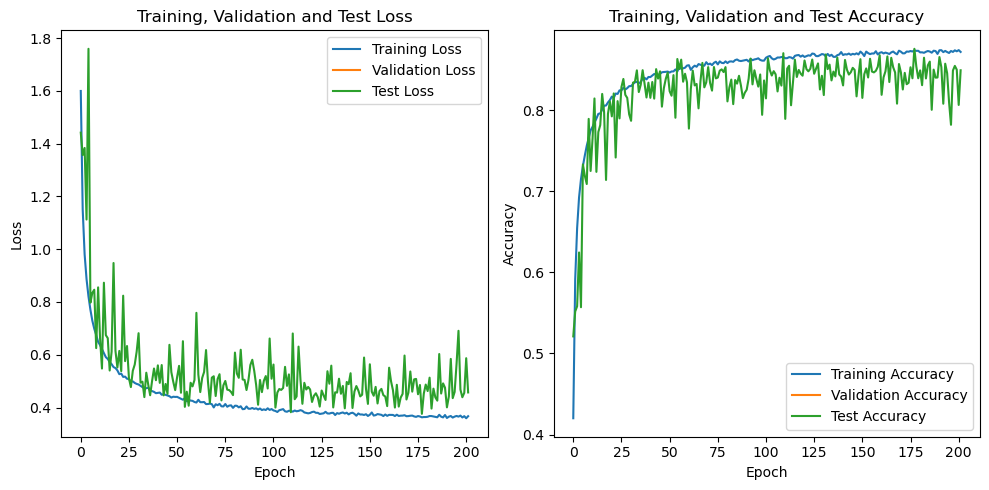

In [52]:
view = LogViewer(logs)
view.draw()

In [53]:
view.print_all()

1 epoch: train_loss=1.5995, train_acc=0.4201, test_loss=1.4416, test_acc=0.5211, lr=0.0020
2 epoch: train_loss=1.1507, train_acc=0.5916, test_loss=1.3564, test_acc=0.5518, lr=0.0020
3 epoch: train_loss=0.9804, train_acc=0.6548, test_loss=1.3836, test_acc=0.5583, lr=0.0020
4 epoch: train_loss=0.8864, train_acc=0.6927, test_loss=1.1124, test_acc=0.6247, lr=0.0020
5 epoch: train_loss=0.8211, train_acc=0.7152, test_loss=1.7593, test_acc=0.5571, lr=0.0020
6 epoch: train_loss=0.7707, train_acc=0.7314, test_loss=0.7974, test_acc=0.7334, lr=0.0020
7 epoch: train_loss=0.7292, train_acc=0.7445, test_loss=0.8346, test_acc=0.7193, lr=0.0020
8 epoch: train_loss=0.6987, train_acc=0.7564, test_loss=0.8465, test_acc=0.7092, lr=0.0020
9 epoch: train_loss=0.6752, train_acc=0.7659, test_loss=0.6252, test_acc=0.7896, lr=0.0020
10 epoch: train_loss=0.6494, train_acc=0.7754, test_loss=0.8554, test_acc=0.7253, lr=0.0020
11 epoch: train_loss=0.6367, train_acc=0.7798, test_loss=0.6630, test_acc=0.7652, lr=0.00

In [54]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))